In [1]:
import h5py
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
import torch.optim as optim
import wandb

from dotenv import load_dotenv
import os
from sklearn.metrics import accuracy_score, f1_score,  roc_curve, auc
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from numpy.random import randn
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

In [3]:
train_meta_path = 'train-metadata.csv'
test_meta_path = 'test-metadata.csv'
train_img_path = 'train-image.hdf5'
test_img_path = 'test-image.hdf5'
check_point_path = 'checkpoints'
model_path = 'models'

In [4]:
train_metadata = pd.read_csv(train_meta_path)
train_metadata = train_metadata.ffill()
train_metadata.info()

C:\Users\lilil\AppData\Local\Temp\ipykernel_17556\3074779756.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_meta_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    401059 non-null  float64
 4   sex                           401059 non-null  object 
 5   anatom_site_general           401059 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


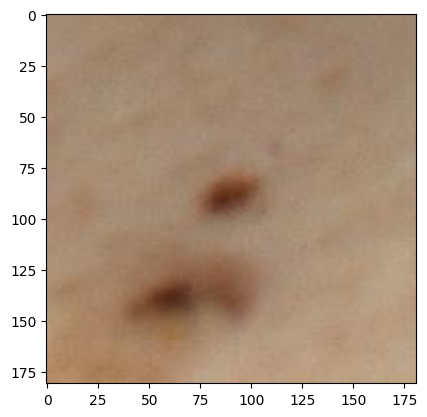

In [17]:
train_val_hdf5  = h5py.File(train_img_path)
test_hdf5 = h5py.File(test_img_path)
isic_id = train_metadata.isic_id.iloc[1250]

# Image as Byte String
byte_string = train_val_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image)

In [18]:

positives = train_metadata[train_metadata['target'] == 1]  # All malignant cases
negatives = train_metadata[train_metadata['target'] == 0]  # All benign cases

pos_patient = set(positives['patient_id'])
neg_patient = set(negatives['patient_id'])
print(f"Number of positive patients: {len(pos_patient)}")
print(f"Number of negative patients: {len(neg_patient)}")

# Find overlap between positive and negative patient IDs
overlap_patient_ids = pos_patient.intersection(neg_patient)

# Check if there is any overlap
if overlap_patient_ids:
    print(f"Overlap found! {len(overlap_patient_ids)} patient(s) have records in both positive and negative cases.")
    print("Overlapping patient IDs:", overlap_patient_ids)
else:
    print("No overlap between positive and negative patient IDs.")


Number of positive patients: 259
Number of negative patients: 1041
Overlap found! 258 patient(s) have records in both positive and negative cases.
Overlapping patient IDs: {'IP_0658218', 'IP_4899312', 'IP_2870467', 'IP_3371534', 'IP_3056186', 'IP_3537591', 'IP_2099415', 'IP_7497380', 'IP_4215006', 'IP_3026867', 'IP_3154471', 'IP_0076153', 'IP_0973797', 'IP_8977835', 'IP_5811816', 'IP_2084621', 'IP_4717387', 'IP_1045174', 'IP_0023586', 'IP_1390102', 'IP_7373371', 'IP_7293666', 'IP_7312348', 'IP_7965642', 'IP_4177511', 'IP_1092190', 'IP_2068150', 'IP_9807499', 'IP_7792811', 'IP_0669361', 'IP_0277335', 'IP_7322743', 'IP_5143034', 'IP_8492485', 'IP_1093030', 'IP_2935407', 'IP_6856511', 'IP_6321403', 'IP_2950091', 'IP_2203964', 'IP_8834083', 'IP_1664093', 'IP_9978624', 'IP_1885773', 'IP_0822819', 'IP_9039449', 'IP_5961877', 'IP_3987348', 'IP_7797815', 'IP_8810058', 'IP_2224950', 'IP_0889220', 'IP_8078890', 'IP_3028432', 'IP_5539318', 'IP_5230038', 'IP_1712091', 'IP_0152575', 'IP_1715157', '

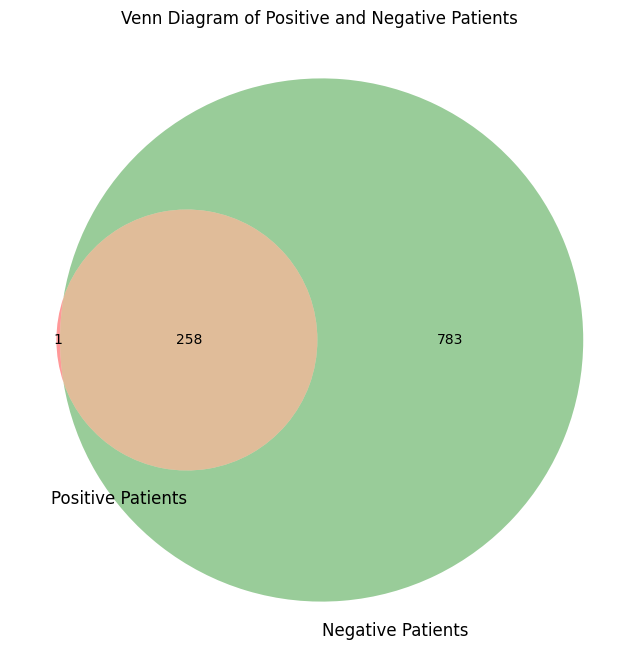

In [32]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Count the number of patients in each set
num_pos_patients = len(pos_patient)
num_neg_patients = len(neg_patient)
num_overlap_patients = len(overlap_patient_ids)

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn = venn2(subsets=(num_pos_patients - num_overlap_patients,  # Only positive cases
                      num_neg_patients - num_overlap_patients,  # Only negative cases
                      num_overlap_patients),                    # Overlap
             set_labels=('Positive Patients', 'Negative Patients'))

# Add title
plt.title("Venn Diagram of Positive and Negative Patients")

# Show the plot
plt.show()


In [19]:
class CFG:
    verbose = 1  # Verbosity
    lr = 0.001  # Learning rate
    image_size = (224, 224) # Image size
    model_name = "mobilenetv2"  # Name of the model
    seed = 42  # Random seed
    neg_sample = 0.01  # Downsample negative class
    pos_sample = 5.0  # Upsample positive class
    preset = "mobilenetv2"  # Name of pretrained classifier
    epochs = 6  # Training epochs
    batch_size = 128  # Batch size
    class_names = ['target']
    num_classes = 1


In [20]:
print("Class Distribution Before Sampling (%):")
print(train_metadata.target.value_counts(normalize=True) * 100)

# Sampling
positive_df = train_metadata.query("target == 1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)  # Upsample positives
negative_df = train_metadata.query("target == 0").sample(frac=CFG.neg_sample, random_state=CFG.seed)  # Downsample negatives
df_sampled = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=CFG.seed)

print("\nClass Distribution After Sampling (%):")
print(df_sampled.target.value_counts(normalize=True) * 100)

Class Distribution Before Sampling (%):
target
0    99.902009
1     0.097991
Name: proportion, dtype: float64

Class Distribution After Sampling (%):
target
0    67.09645
1    32.90355
Name: proportion, dtype: float64


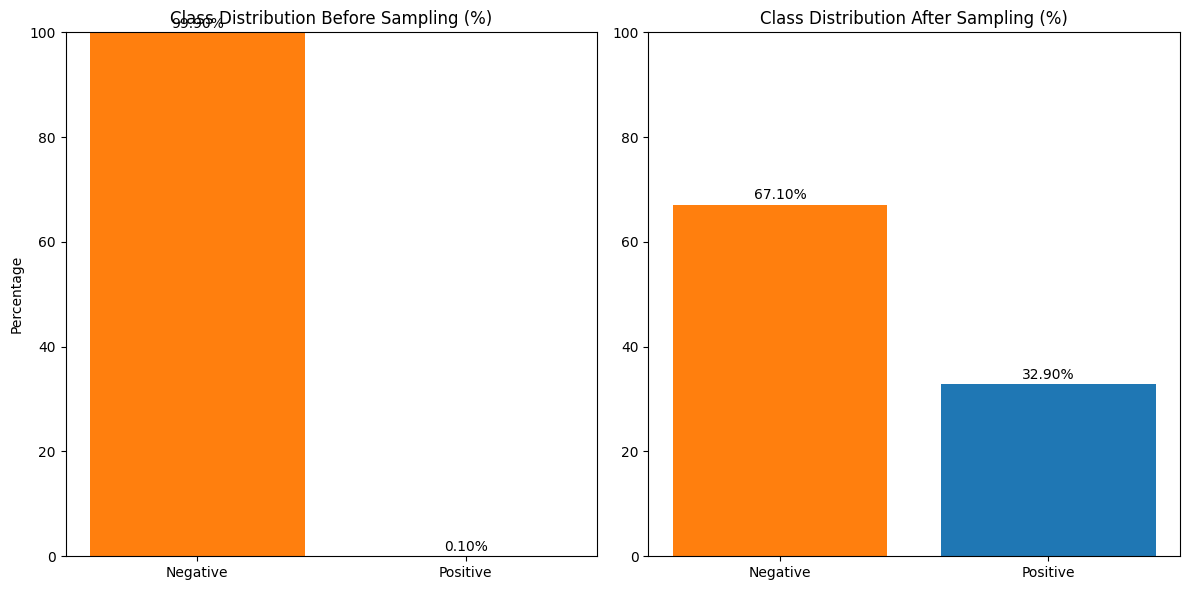

In [33]:
import matplotlib.pyplot as plt

# Class distribution before sampling
class_dist_before = train_metadata.target.value_counts(normalize=True) * 100

# Class distribution after sampling
class_dist_after = df_sampled.target.value_counts(normalize=True) * 100

# Plotting the class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before Sampling
axes[0].bar(['Negative', 'Positive'], class_dist_before, color=['tab:orange', 'tab:blue'])
axes[0].set_title('Class Distribution Before Sampling (%)')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)
for i, v in enumerate(class_dist_before):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center')

# After Sampling
axes[1].bar(['Negative', 'Positive'], class_dist_after, color=['tab:orange', 'tab:blue'])
axes[1].set_title('Class Distribution After Sampling (%)')
axes[1].set_ylim(0, 100)
for i, v in enumerate(class_dist_after):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center')

plt.tight_layout()
plt.show()


In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df_sampled['target']), y=df_sampled['target'])
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


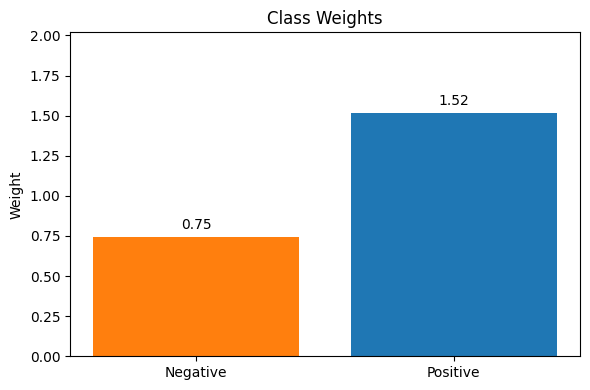

In [34]:
class_labels = ['Negative', 'Positive'] 
weights = list(class_weights.values())


plt.figure(figsize=(6, 4))
plt.bar(class_labels, weights, color=['tab:orange', 'tab:blue'])
plt.title('Class Weights')
plt.ylabel('Weight')
plt.ylim(0, max(weights) + 0.5)
for i, v in enumerate(weights):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


In [36]:
from sklearn.model_selection import StratifiedGroupKFold

df = df_sampled.reset_index(drop=True) 

# Initialize the fold column with -1
df["fold"] = -1

# Stratified Group K-Fold split ensuring stratification on 'target' and grouping by 'patient_id'
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Split and assign fold numbers
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use fold 0 for validation, and the rest for training
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")

print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


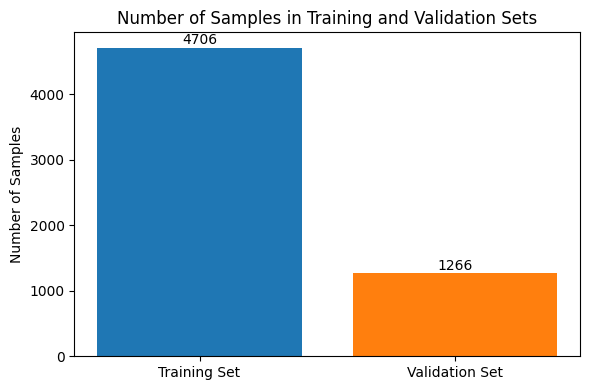

In [37]:
plt.figure(figsize=(6, 4))
plt.bar(['Training Set', 'Validation Set'], [len(training_df), len(validation_df)], color=['tab:blue', 'tab:orange'])
plt.title('Number of Samples in Training and Validation Sets')
plt.ylabel('Number of Samples')


plt.text(0, len(training_df) + 50, f'{len(training_df)}', ha='center')
plt.text(1, len(validation_df) + 50, f'{len(validation_df)}', ha='center')

plt.tight_layout()
plt.show()

In [11]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [12]:
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [13]:
## Train
print("# Training:")
training_features = dict(training_df[FEAT_COLS])
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, train_val_hdf5, training_features, 
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = dict(validation_df[FEAT_COLS])
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, train_val_hdf5, validation_features,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

In [14]:
feature_space = keras.utils.FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

In [15]:
training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
feature_space.adapt(training_ds_with_no_labels)

In [16]:
for x, _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (128, 71)
preprocessed_x.dtype: <dtype: 'float32'>


In [21]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (128, 224, 224, 3)
Features: (128, 71)
Targets: (128, 1)


In [23]:
class PartialAUC(tf.keras.metrics.Metric):
    def __init__(self, name="pAUC", min_tpr=0.80, **kwargs):
        super(PartialAUC, self).__init__(name=name, **kwargs)
        self.min_tpr = min_tpr
        self.partial_auc = self.add_weight(name="pAUC", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        pAUC_value = tf.py_function(
            func=self.calculate_pAUC,  
            inp=[y_true, y_pred],      
            Tout=tf.float32            
        )
        pAUC_value = tf.ensure_shape(pAUC_value, [])

        # Update state
        self.partial_auc.assign_add(pAUC_value)
        self.total_samples.assign_add(1.0)

    def result(self):
        return self.partial_auc / self.total_samples

    def reset_states(self):
        self.partial_auc.assign(0.0)
        self.total_samples.assign(0.0)

    def calculate_pAUC(self, y_true, y_pred):
        # Convert Tensor to NumPy arrays
        solution = y_true.numpy()
        submission = y_pred.numpy()

        v_gt = abs(np.asarray(solution) - 1)
        v_pred = -1.0 * np.asarray(submission)
        max_fpr = abs(1 - self.min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)

        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % self.min_tpr)

        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)

        return np.float32(partial_auc)


In [24]:
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)
# auc = keras.metrics.AUC()

In [25]:
image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")
inp = {"images":image_input, "features":feat_input}

In [42]:
from tensorflow.keras.applications import MobileNetV2
backbone = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x1 = backbone(image_input)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)

x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.5)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)

# Build model
model = keras.models.Model(inp, out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=[PartialAUC(min_tpr=0.80)],
)

# Model Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ images[0][0]      │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     12,416 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1408)      │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      1,409 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,278,721 (8.69 MB)

 Trainable params: 2,244,609 (8.56 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [28]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

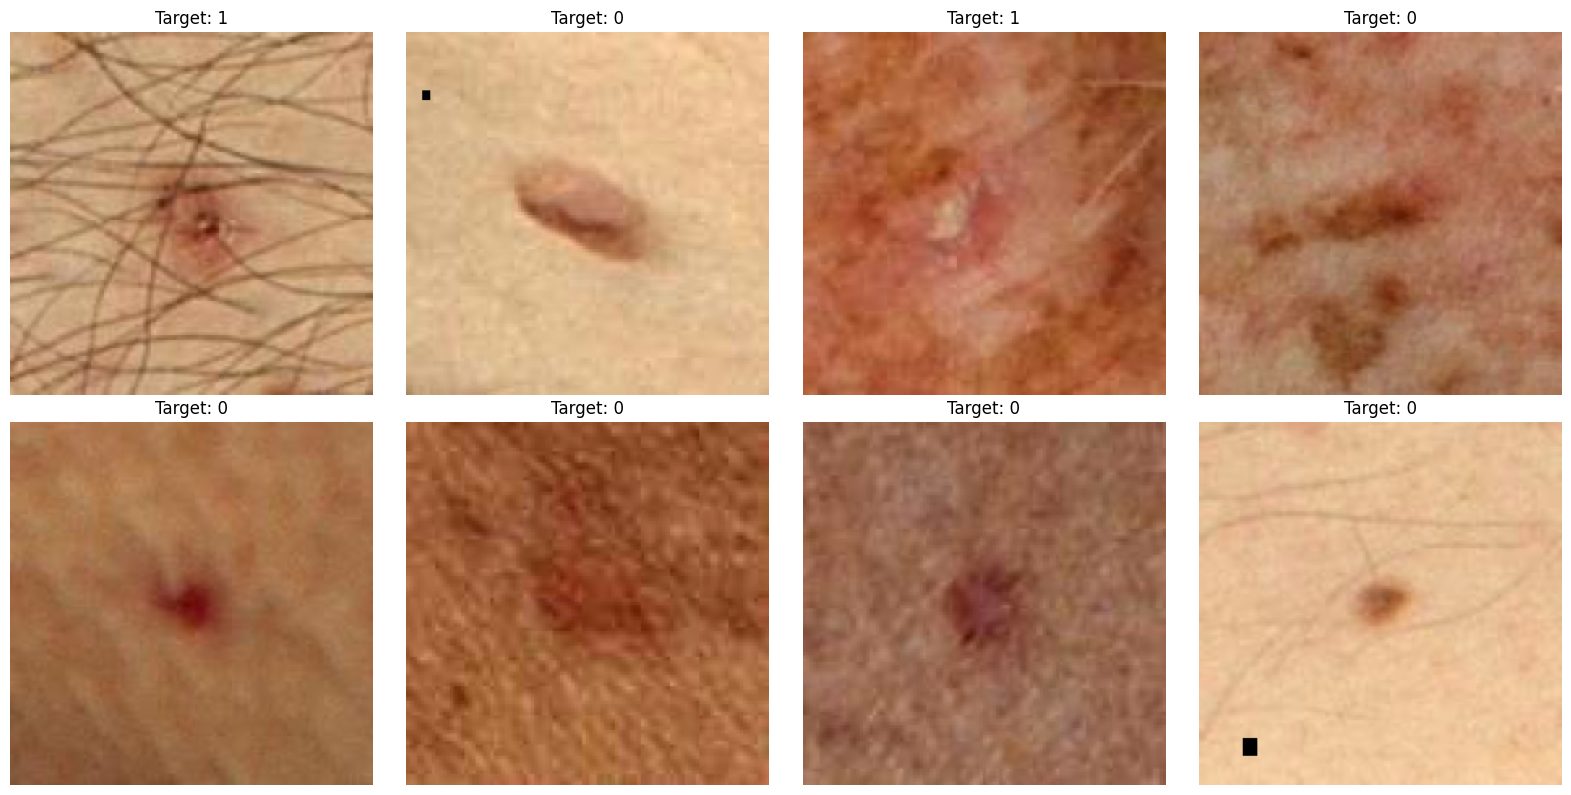

In [29]:
inputs, targets = next(iter(training_ds))
images = inputs["images"]
num_images, NUMERIC_COLUMNS = 8, 4

plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, target) in enumerate(zip(images[:num_images], targets[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i + 1)
    image = image.numpy().astype("float32")
    target= target.numpy().astype("int32")[0]
    
    image = (image - image.min()) / (image.max() + 1e-4)

    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

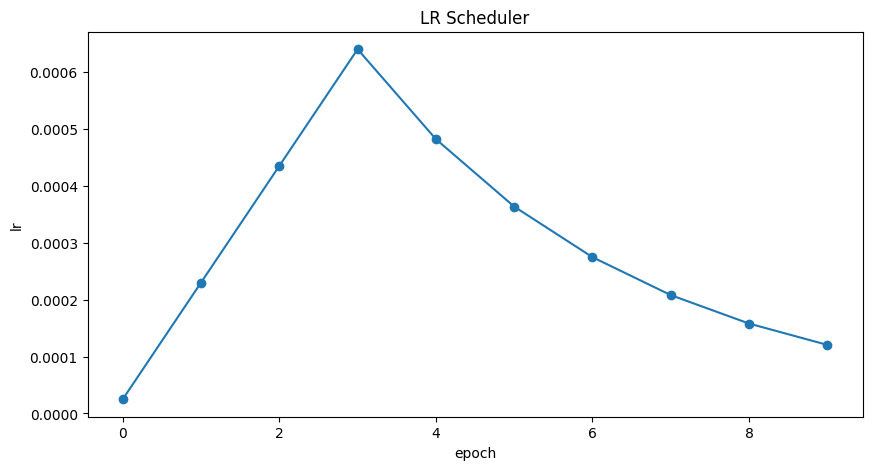

In [38]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

In [39]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_pAUC",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

In [40]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 42:44 71s/step - loss: 0.8106 - pAUC: 0.032 ━━━━━━━━━━━━━━━━━━━━ 8:42 15s/step - loss: 0.8116 - pAUC: 0.029 ━━━━━━━━━━━━━━━━━━━━ 8:09 14s/step - loss: 0.7997 - pAUC: 0.02 ━━━━━━━━━━━━━━━━━━━━ 7:51 14s/step - loss: 0.7906 - pAUC: 0.02 ━━━━━━━━━━━━━━━━━━━━ 7:32 14s/step - loss: 0.7881 - pAUC: 0.02 ━━━━━━━━━━━━━━━━━━━━ 7:16 14s/step - loss: 0.7857 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 7:03 14s/step - loss: 0.7840 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 6:49 14s/step - loss: 0.7816 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 6:34 14s/step - loss: 0.7799 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 6:19 14s/step - loss: 0.7774 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 6:05 14s/step - loss: 0.7752 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 5:50 14s/step - loss: 0.7731 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 5:37 14s/step - loss: 0.7709 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 5:22 14s/step - loss: 0.7684 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 5:08 14s/step - loss: 0.7660 - pAUC: 0.03 ━━━━━━━━━━━━━━━━━━━━ 4:54 14s/step -

In [87]:
print(history.history.keys())


dict_keys(['loss', 'pAUC', 'val_loss', 'val_pAUC', 'learning_rate'])


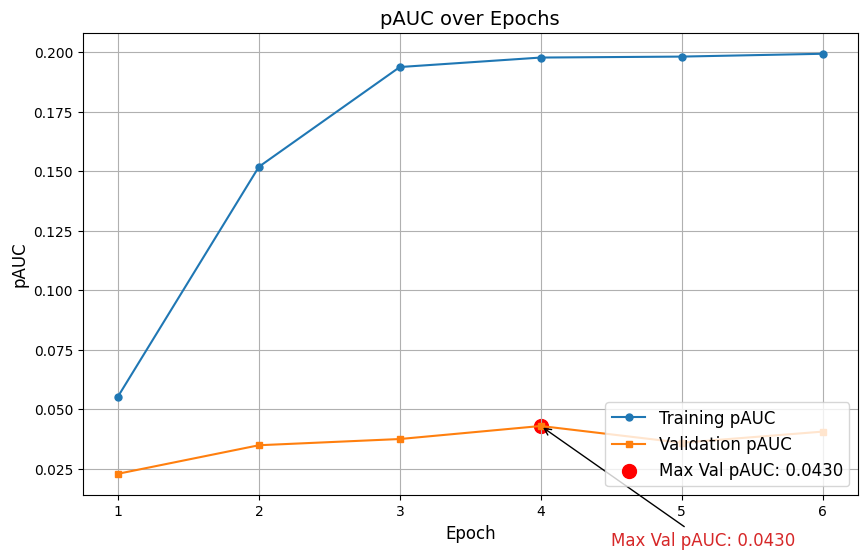

In [41]:
pauc = history.history['pAUC']
val_pauc = history.history['val_pAUC']
epochs = range(1, len(pauc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_pauc)
max_val_auc = val_pauc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, pauc, 'o-', label='Training pAUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_pauc, 's-', label='Validation pAUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val pAUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val pAUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('pAUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('pAUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

In [44]:
# Best Result
best_score = max(history.history['val_pAUC'])
best_epoch = np.argmax(history.history['val_pAUC']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best PAUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best PAUC: 0.04304
Best Epoch: 4
############################
